In [53]:
import scanpy as sc 
import pandas as pd
import os
import warnings
import anndata as ad
from anndata import AnnData

warnings.filterwarnings('ignore') 

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [3]:
results_file = "C:/Users/supak/github/resultsc/GSE184950_test.h5ad"

In [4]:
directory = 'C:/Users/supak/workplace/singlecell/GSE184950_RAW/data_selected/'
dirs = os.listdir(directory)
print(dirs)

['GSM5602315_A10_CTL_filtered_feature_bc_matrix', 'GSM5602316_A15_PDD_filtered_feature_bc_matrix', 'GSM5602317_A18_PDD_filtered_feature_bc_matrix', 'GSM5602318_A2_CTL_filtered_feature_bc_matrix']


In [5]:
dfs = []

patient_adata_list = []

for filename in dirs:
    
    name = filename.replace('_filtered_feature_bc_matrix', '').split('_')
    Patient = name[1]
    Type = name[2]
    
    matrix_file = os.path.join(directory, filename)
    
    adata = sc.read_10x_mtx(matrix_file,
                            var_names='gene_symbols')
    
    adata.var_names_make_unique()
    
    patient_adata_list.append(adata)
        
    adata.obs['Patient'] = Patient
    adata.obs['Type'] = Type
    
    df = pd.DataFrame(adata.obs)
    
    dfs.append(df)
    
merge_df = pd.concat(dfs)



--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [6]:
merged_adata = ad.concat(patient_adata_list, join='outer', merge='same')

c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
print(merged_adata.obs.value_counts())
print(merged_adata.obs.Patient)

Patient  Type
A18      PDD     17752
A15      PDD     11760
A2       CTL     11055
A10      CTL      2165
Name: count, dtype: int64
AAACCCACATCGCTAA-1    A10
AAACCCATCACATACG-1    A10
AAACCCATCGCAACAT-1    A10
AAACGAATCACAATGC-1    A10
AAACGAATCTAACGCA-1    A10
                     ... 
TTTGTTGCAGACTGCC-1     A2
TTTGTTGGTGTCTTGA-1     A2
TTTGTTGTCGAGTTGT-1     A2
TTTGTTGTCTGTAAGC-1     A2
TTTGTTGTCTTACGTT-1     A2
Name: Patient, Length: 42732, dtype: object


In [8]:
merged_adata.var["mt"] = merged_adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    merged_adata, qc_vars=["mt"], 
    percent_top=None, 
    log1p=False, 
    inplace=True)

In [9]:
merged_adata

AnnData object with n_obs × n_vars = 42732 × 33538
    obs: 'Patient', 'Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## **Plot QC**

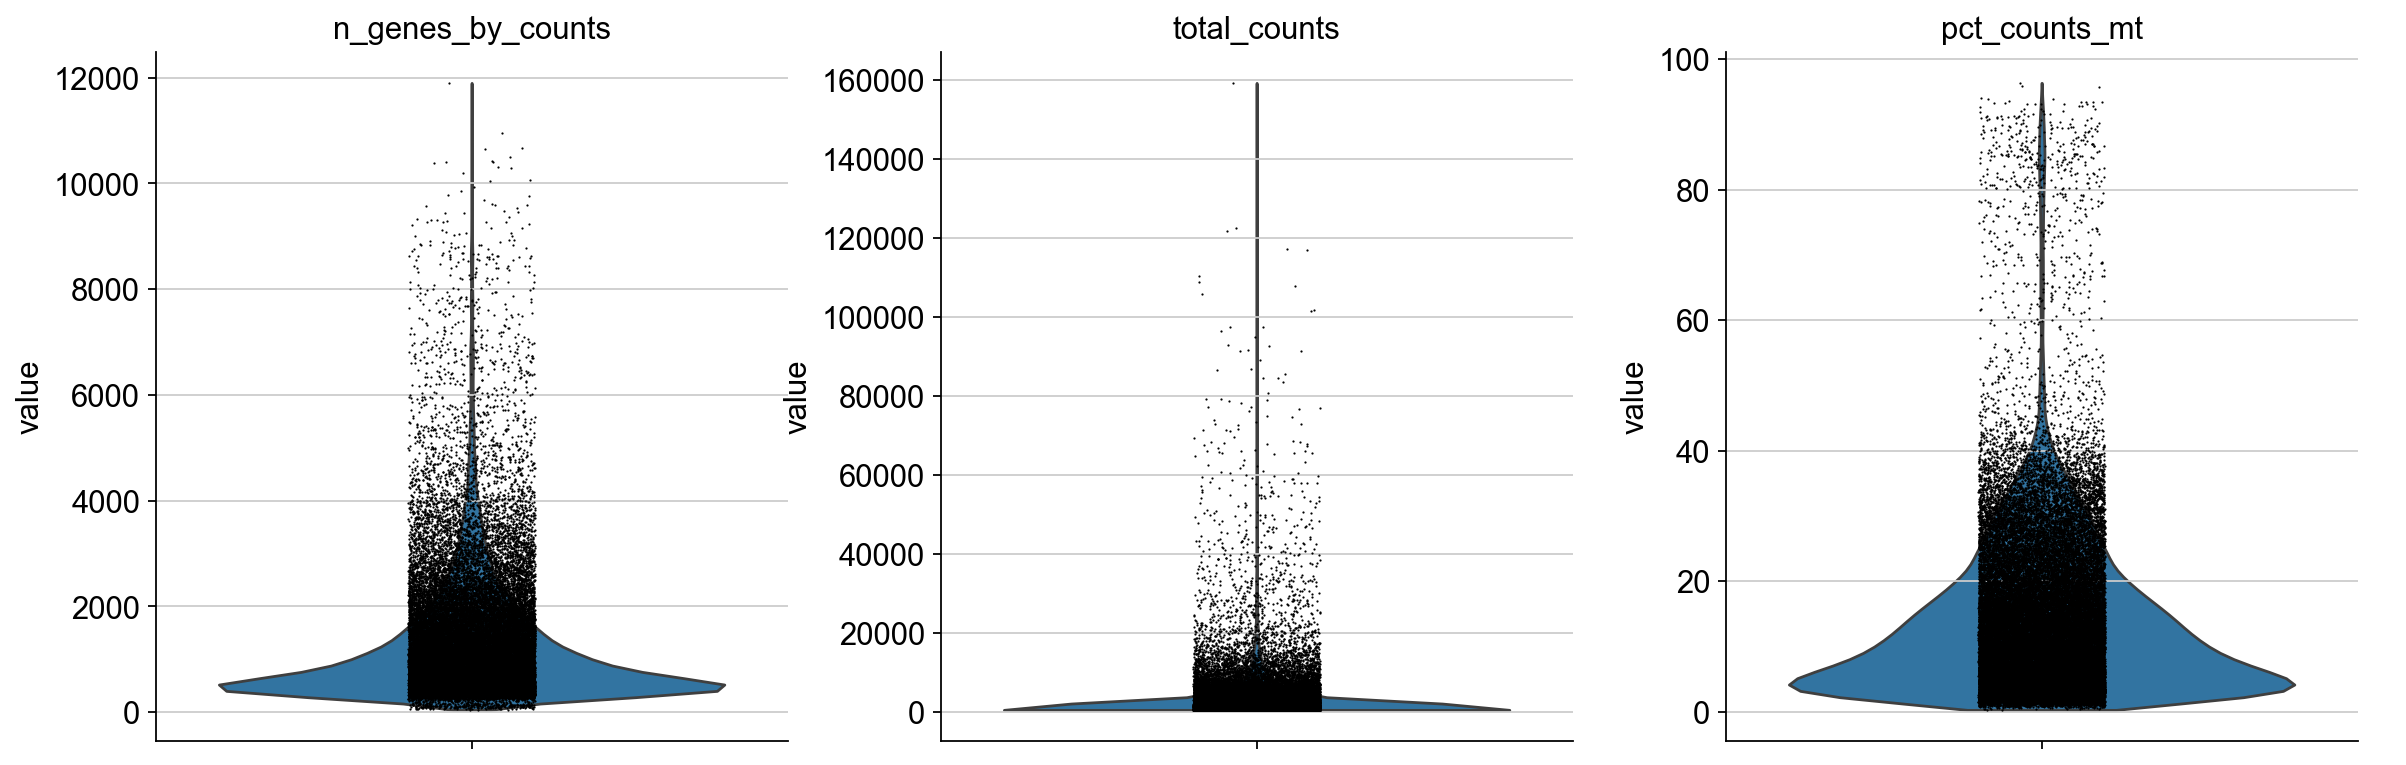

In [10]:
sc.pl.violin(
    merged_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.1,
    multi_panel=True)

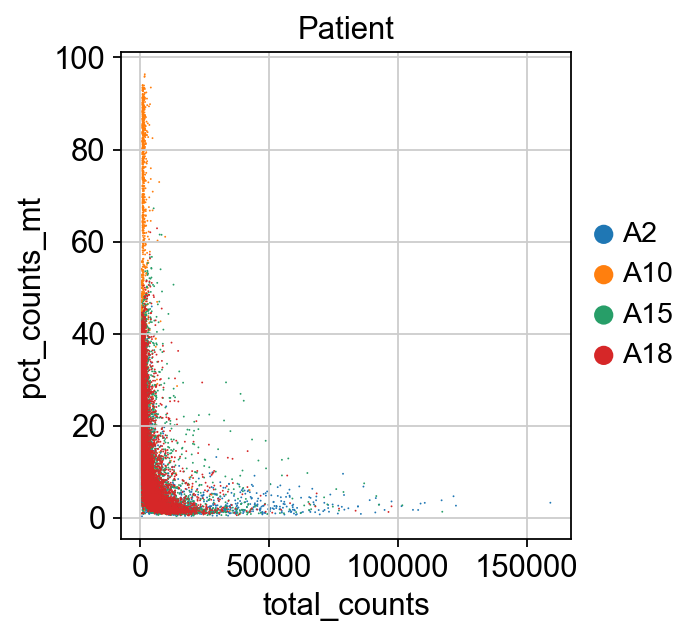

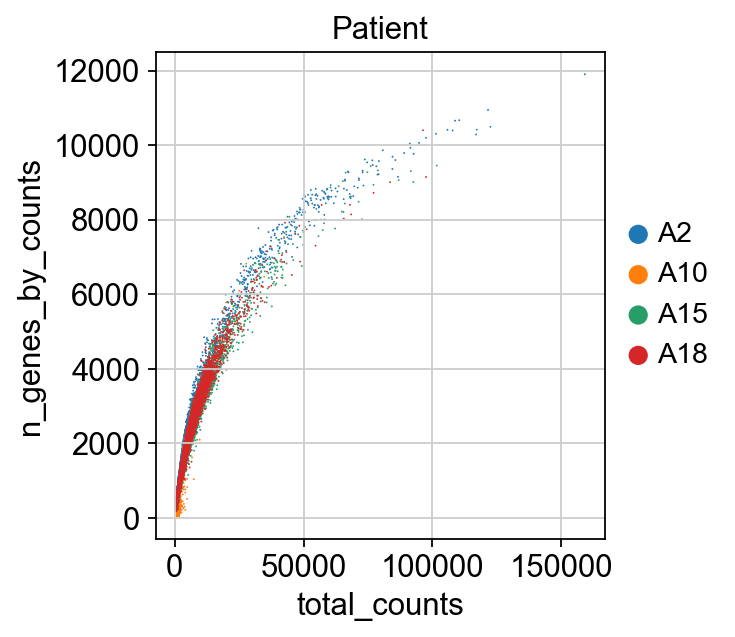

In [11]:
sc.pl.scatter(merged_adata, x="total_counts", y="pct_counts_mt", color="Patient")
sc.pl.scatter(merged_adata, x="total_counts", y="n_genes_by_counts", color="Patient")

## **Filtering**

In [12]:
sc.pp.filter_cells(merged_adata, min_genes=200)
sc.pp.filter_cells(merged_adata, max_genes=5000)
merged_adata = merged_adata[merged_adata.obs.pct_counts_mt < 20, :]
merged_adata = merged_adata[merged_adata.obs.total_counts < 20000, :]
merged_adata = merged_adata[merged_adata.obs.total_counts > 300, :]

filtered out 341 cells that have less than 200 genes expressed


c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 716 cells that have more than 5000 genes expressed


In [13]:
merged_adata

View of AnnData object with n_obs × n_vars = 31624 × 33538
    obs: 'Patient', 'Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Patient_colors'

normalizing counts per cell


c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


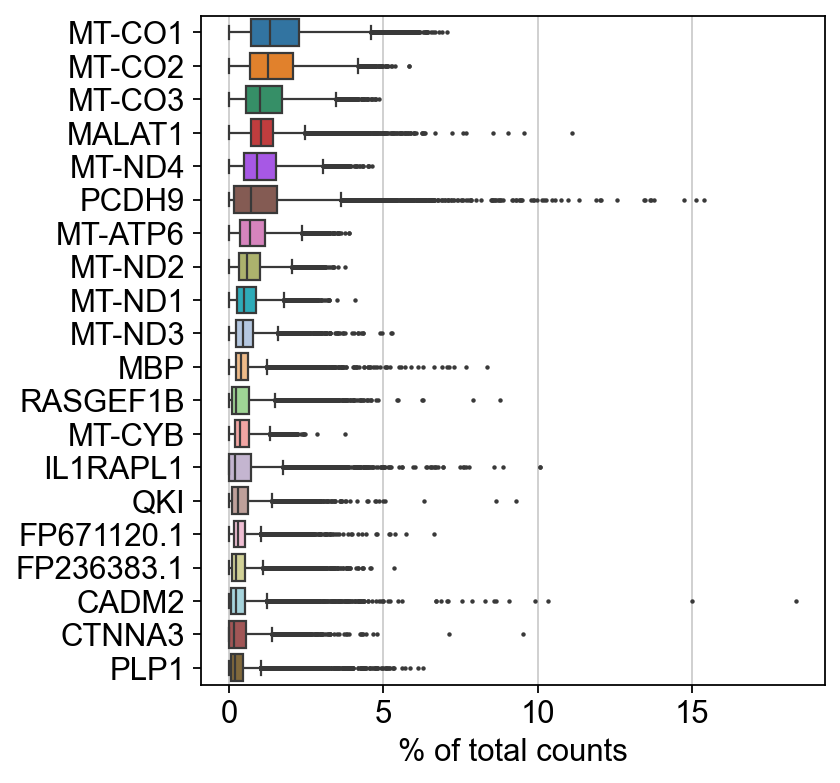

In [14]:
sc.pl.highest_expr_genes(merged_adata, n_top=20)

### **Plot after filtering**

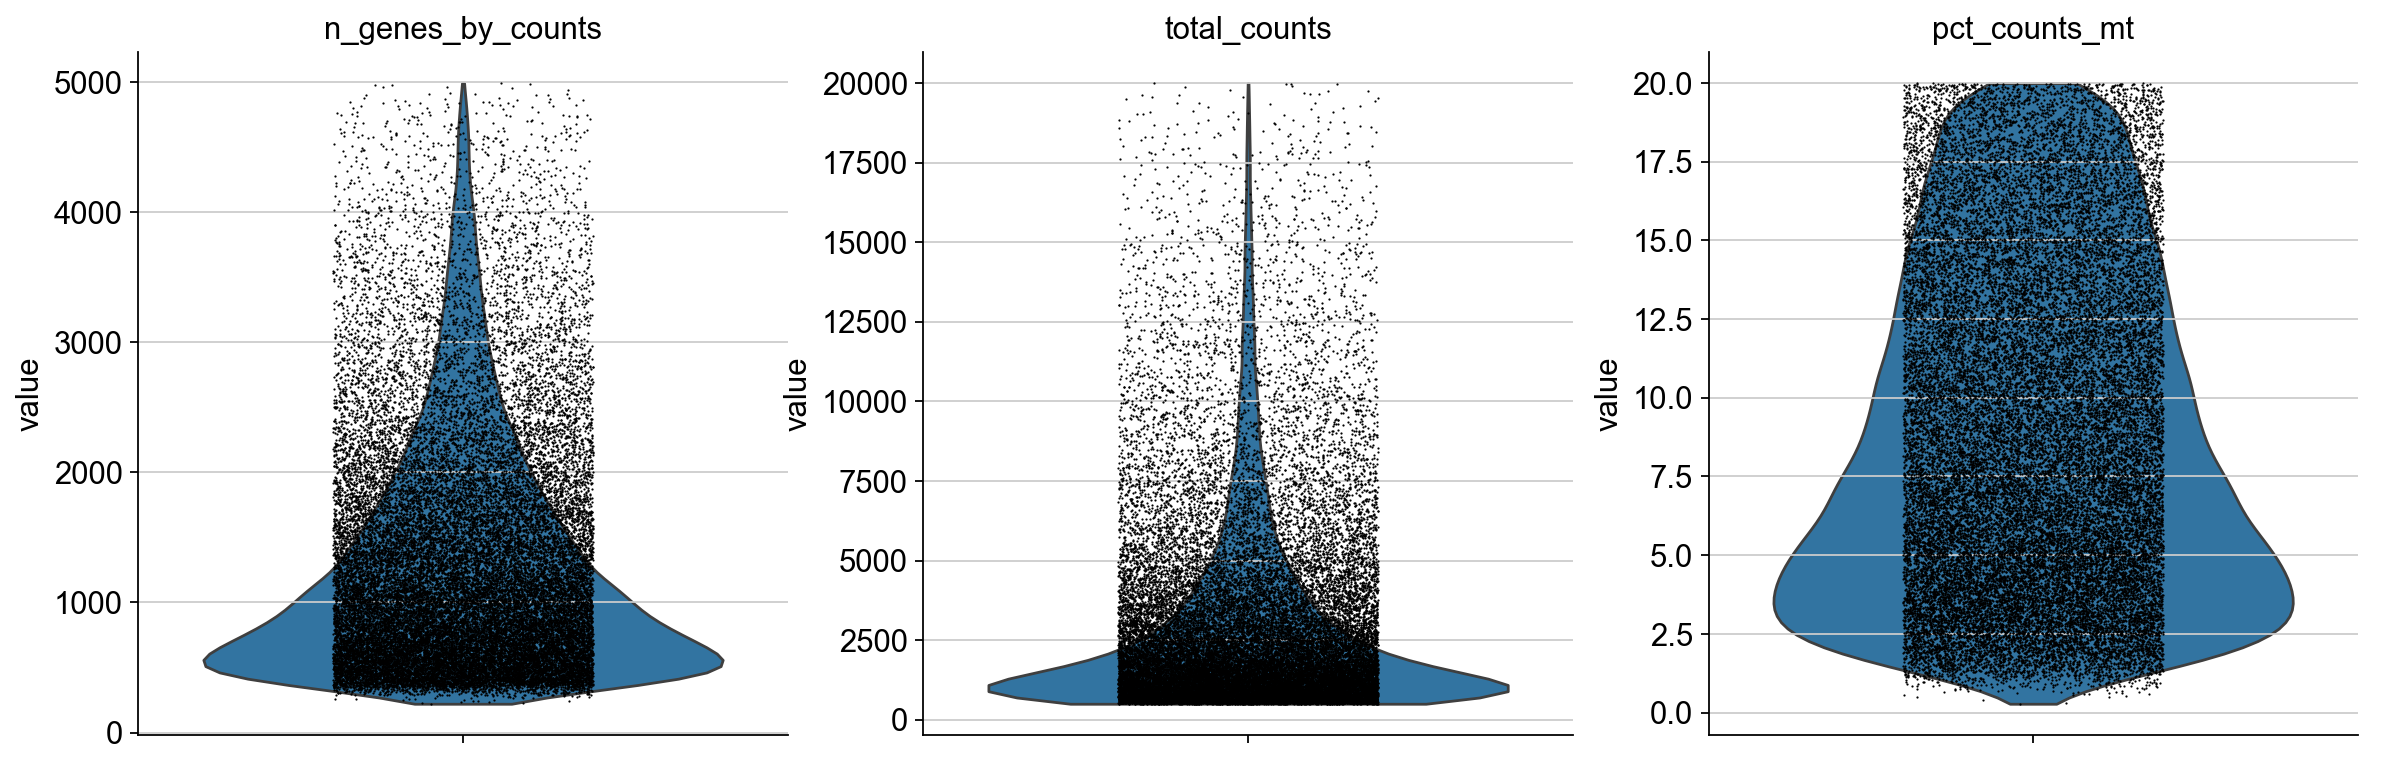

In [15]:
sc.pl.violin(
    merged_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.2,
    multi_panel=True)

## **Normalization**

In [16]:
sc.pp.normalize_total(merged_adata, target_sum=1e4)

normalizing counts per cell


    finished (0:00:00)


In [17]:
sc.pp.log1p(merged_adata)

In [18]:
sc.pp.highly_variable_genes(merged_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes


c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


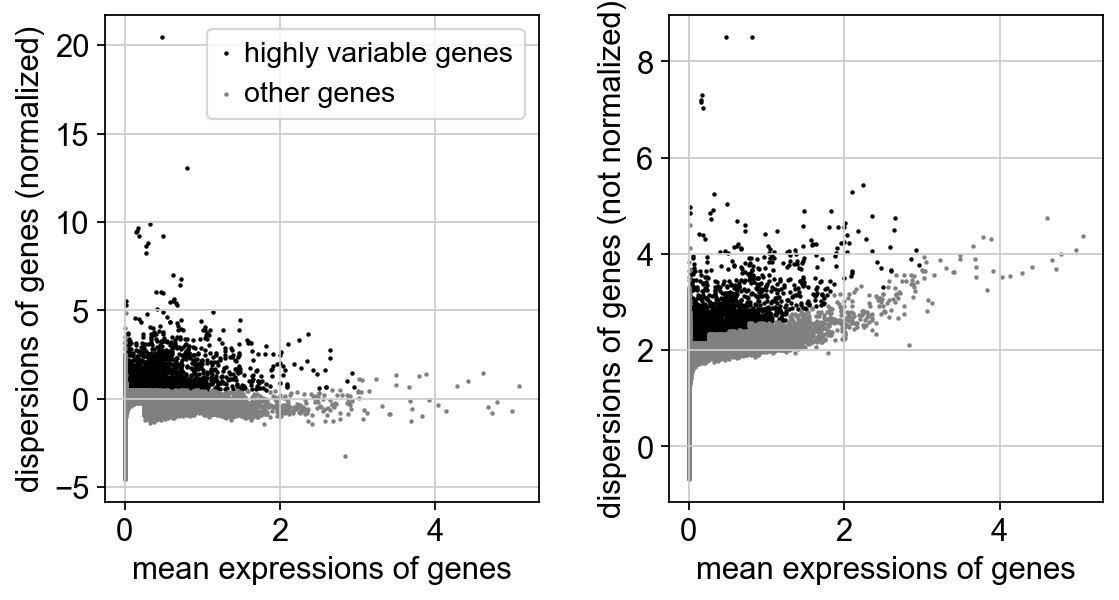

In [19]:
sc.pl.highly_variable_genes(merged_adata)

In [20]:
merged_adata.raw = merged_adata

In [21]:
merged_adata = merged_adata[:, merged_adata.var.highly_variable]

In [22]:
#sc.pp.regress_out(merged_adata, "pct_counts_mt")

In [23]:
sc.pp.scale(merged_adata, max_value=10)

c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
sc.tl.pca(merged_adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


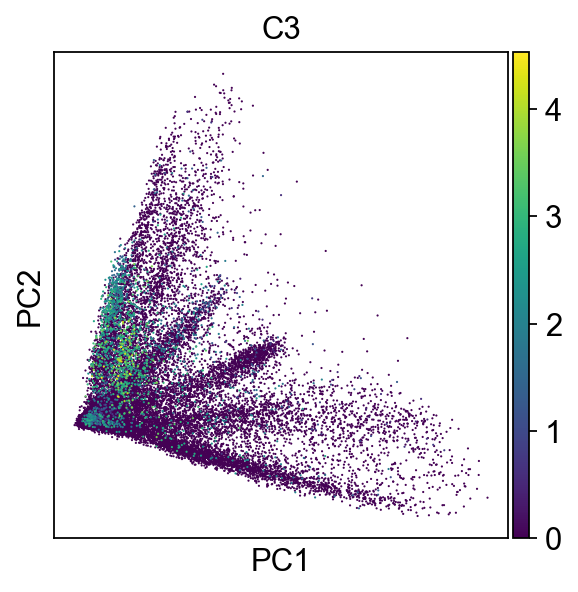

In [25]:
sc.pl.pca(merged_adata, color="C3")

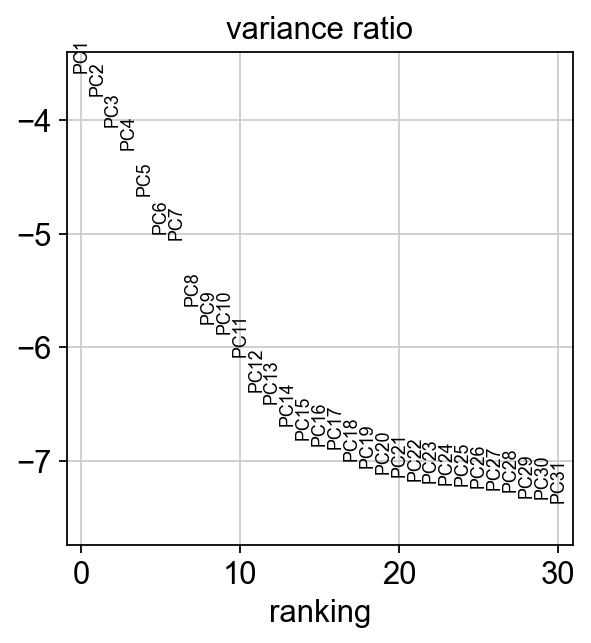

In [26]:
sc.pl.pca_variance_ratio(merged_adata, log=True)

In [27]:
merged_adata.write(results_file)

In [28]:
merged_adata

AnnData object with n_obs × n_vars = 31624 × 4685
    obs: 'Patient', 'Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Patient_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
sc.pp.neighbors(merged_adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


In [30]:
sc.tl.umap(merged_adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


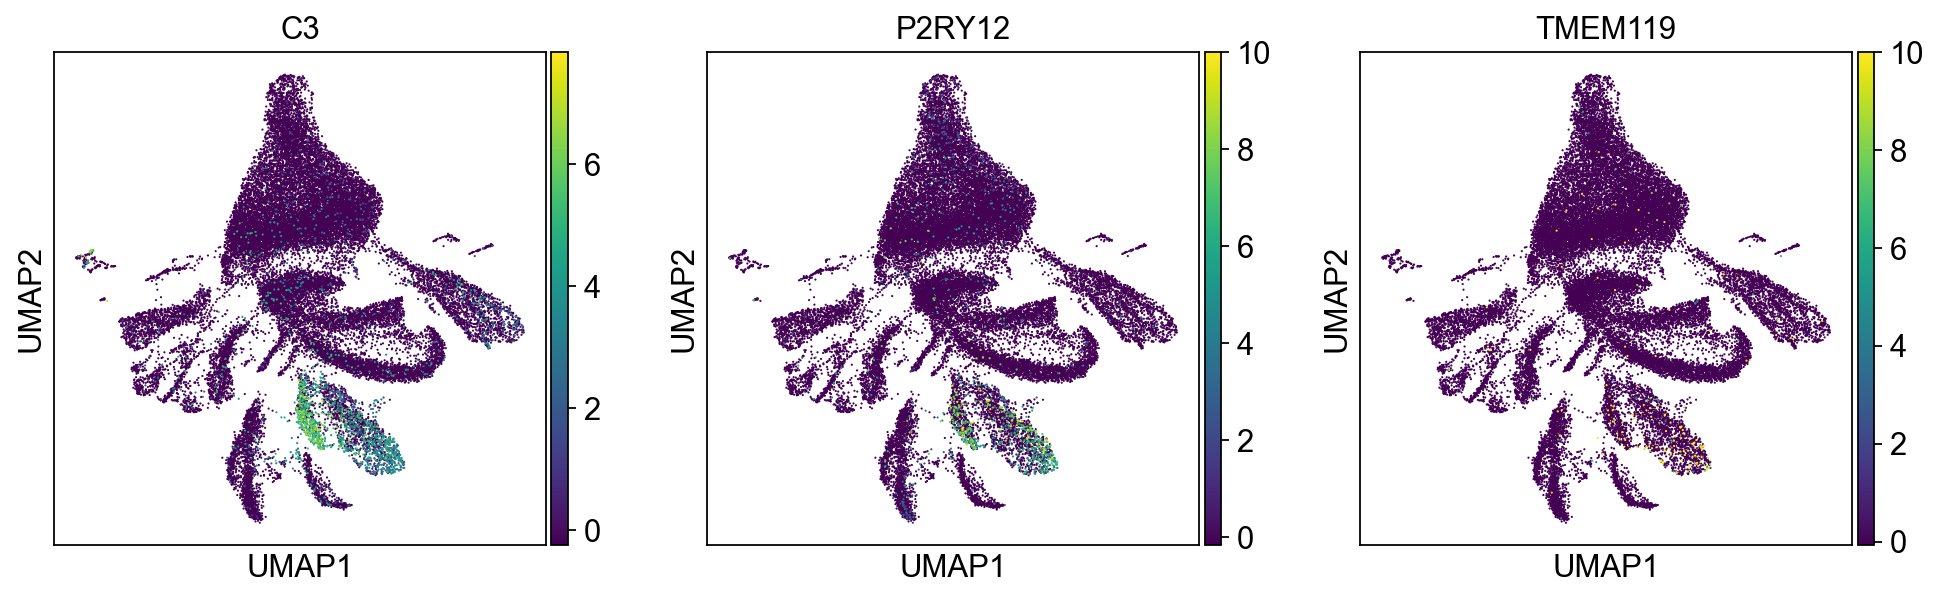

In [50]:
sc.pl.umap(merged_adata, color=["C3", "P2RY12", "TMEM119"], use_raw=False)

In [32]:
sc.tl.leiden(
    merged_adata,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [33]:
merged_adata.var_names

Index(['NOC2L', 'HES4', 'ISG15', 'SDF4', 'B3GALT6', 'CPTP', 'DVL1', 'MXRA8',
       'AURKAIP1', 'MRPL20',
       ...
       'SUMO3', 'ITGB2', 'AP001505.1', 'ADARB1', 'SLC19A1', 'PCBP3', 'COL6A1',
       'COL6A2', 'FTCD', 'AC007325.4'],
      dtype='object', length=4685)

c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


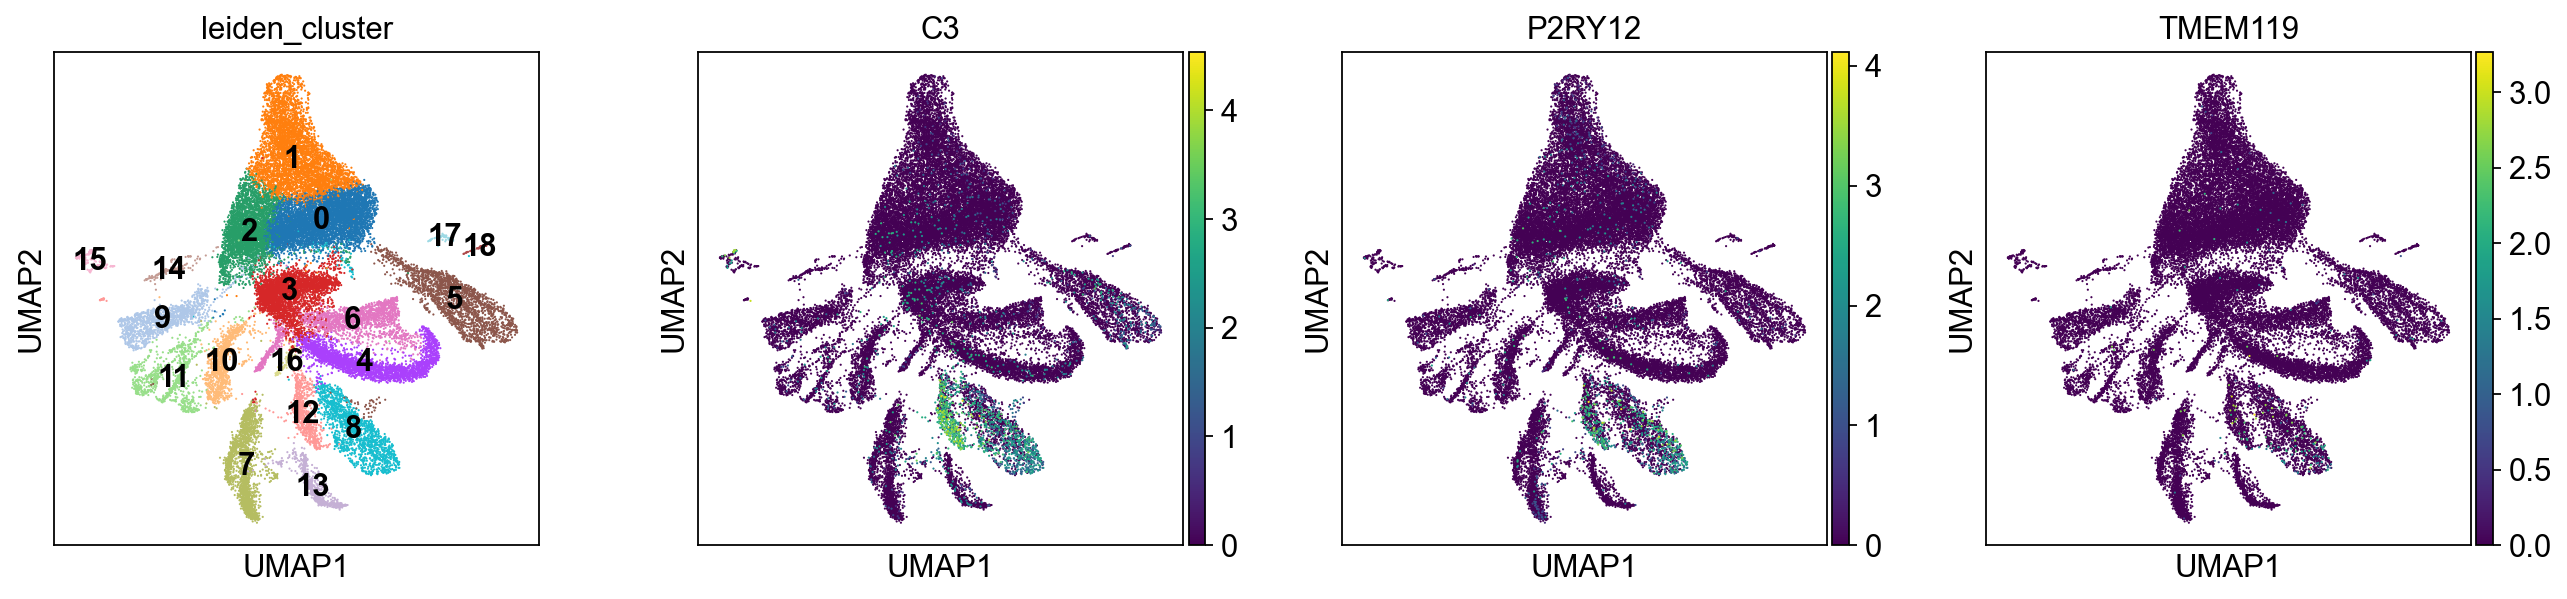

In [46]:
sc.pl.umap(merged_adata, color=["leiden", "C3", "P2RY12", "TMEM119"], legend_loc="on data", title="leiden_cluster")

In [35]:
merged_adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


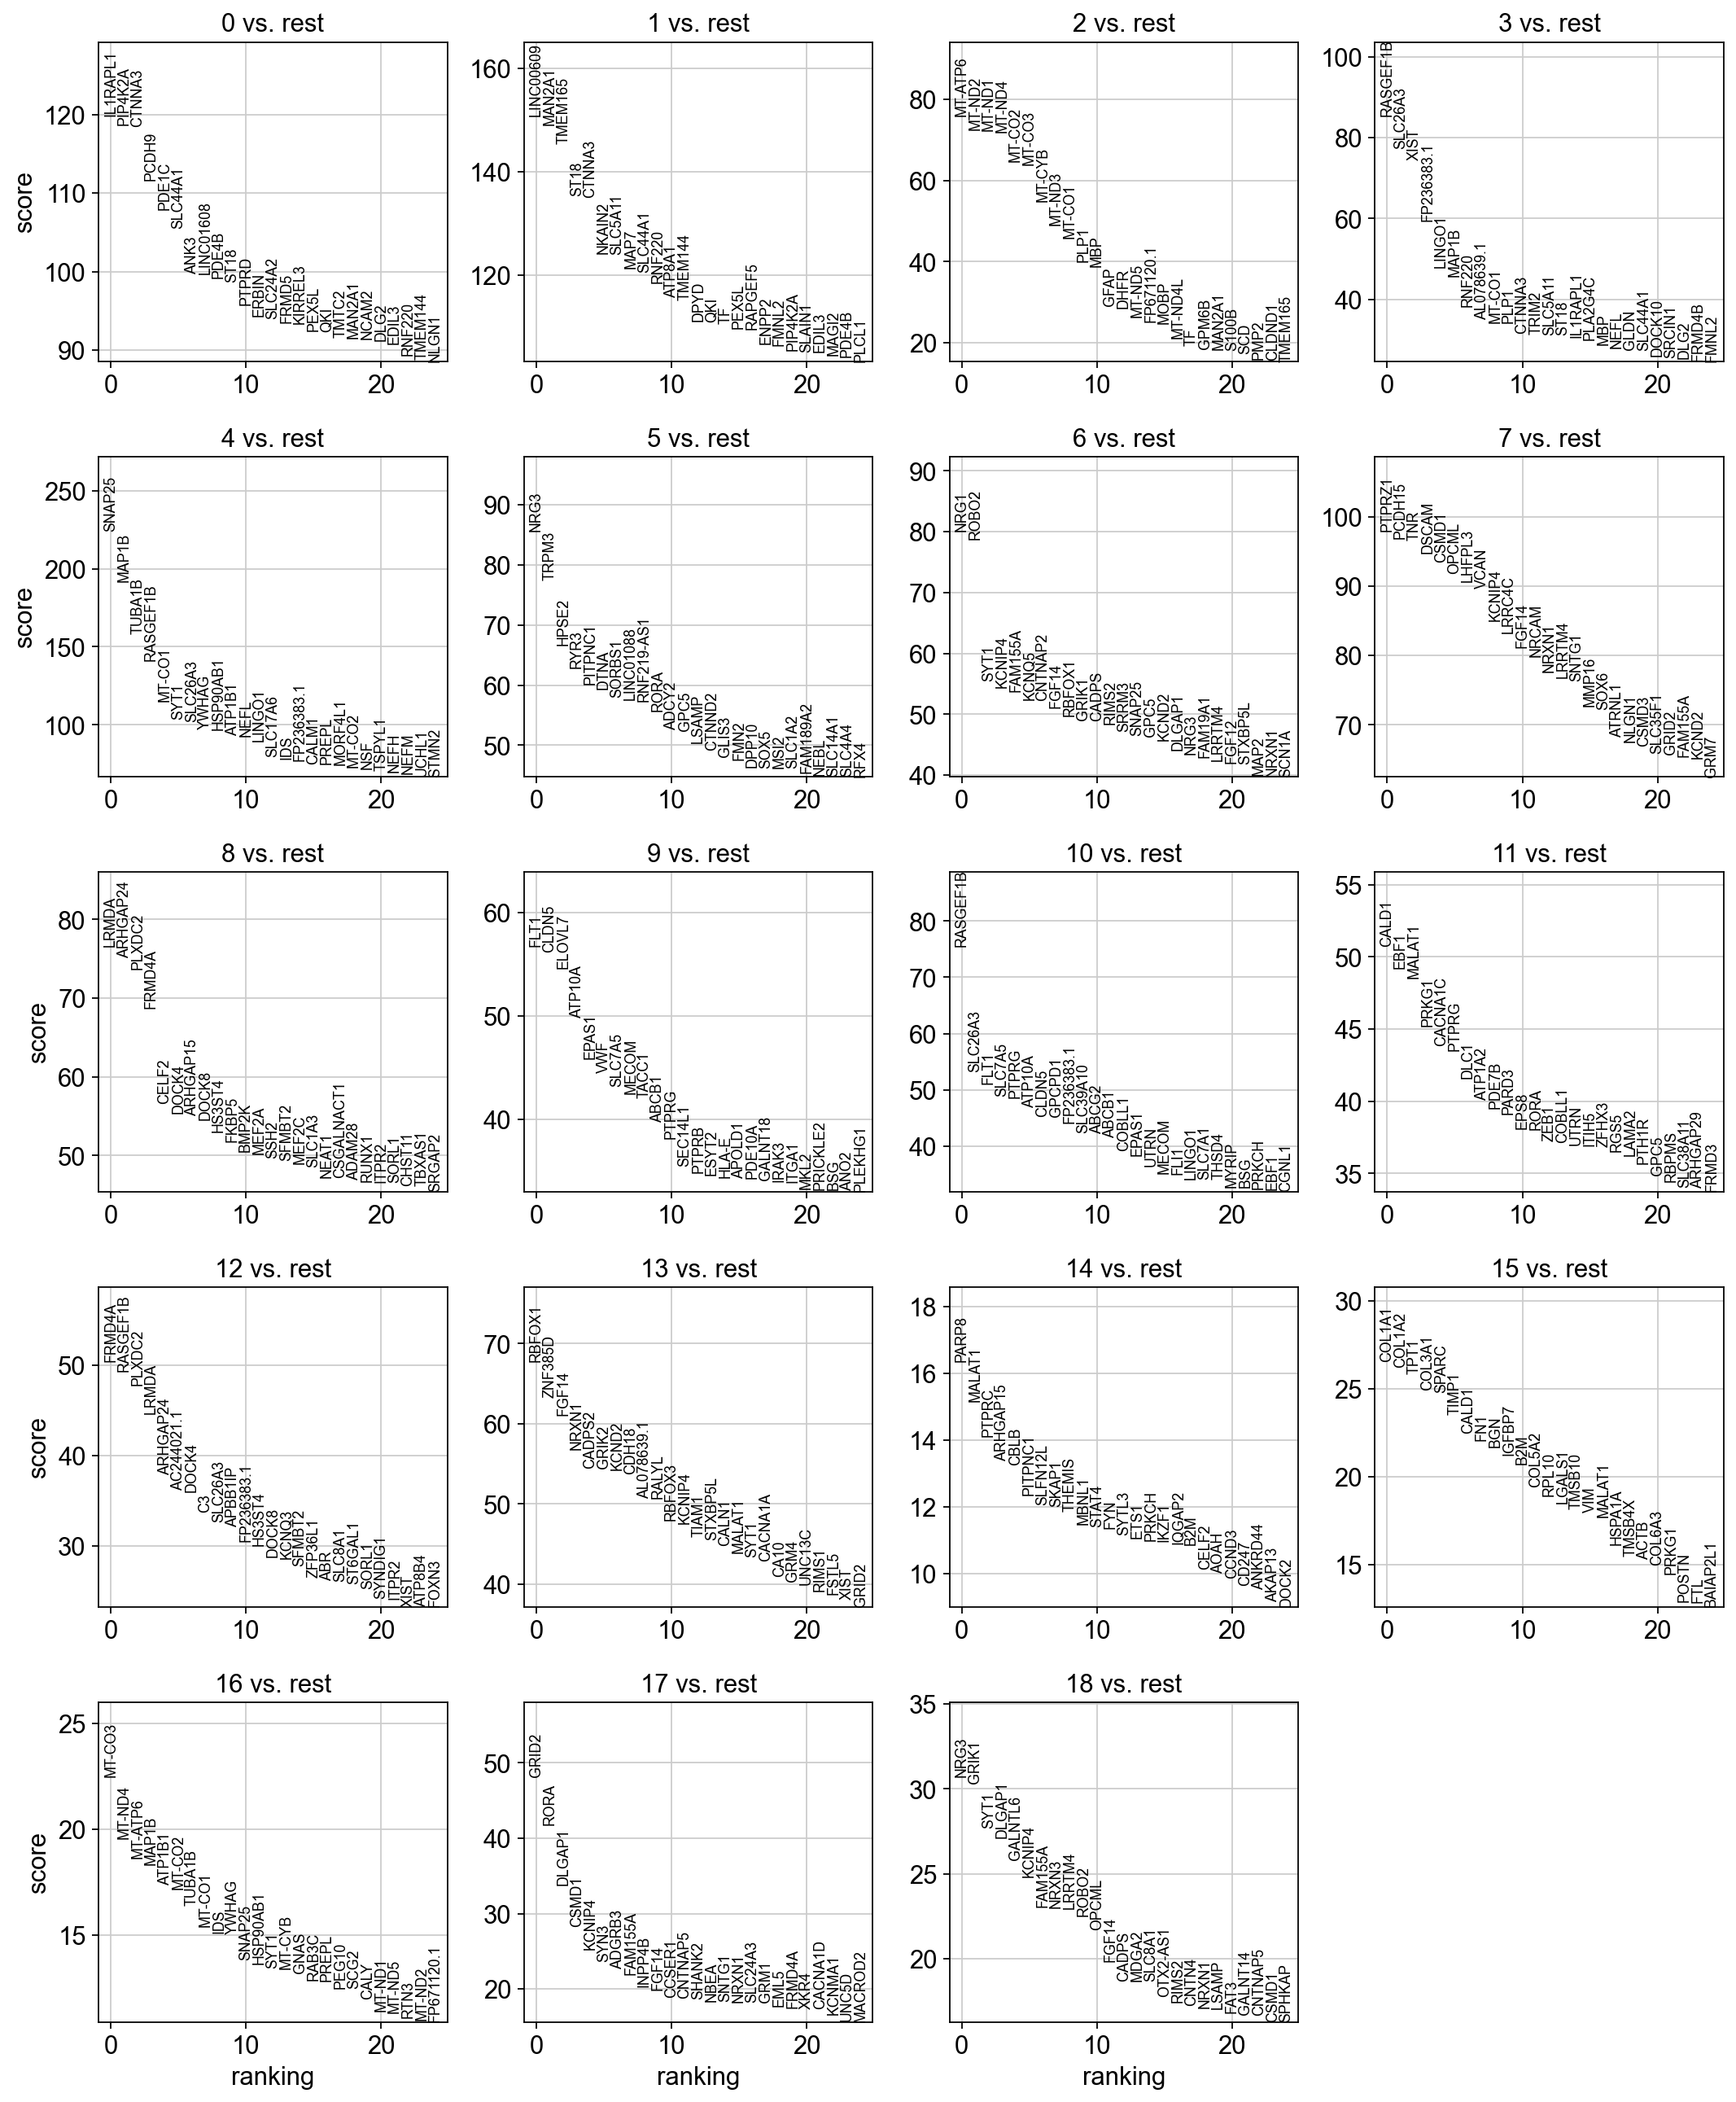

In [36]:
# Methods can be 't-test', 't-test_overestim_var' for overreestimates varience of each group
# 'wilcoxon' for rank-sum
# 'logreg' for logistic regression

sc.tl.rank_genes_groups(merged_adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [37]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes


c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:01:47)


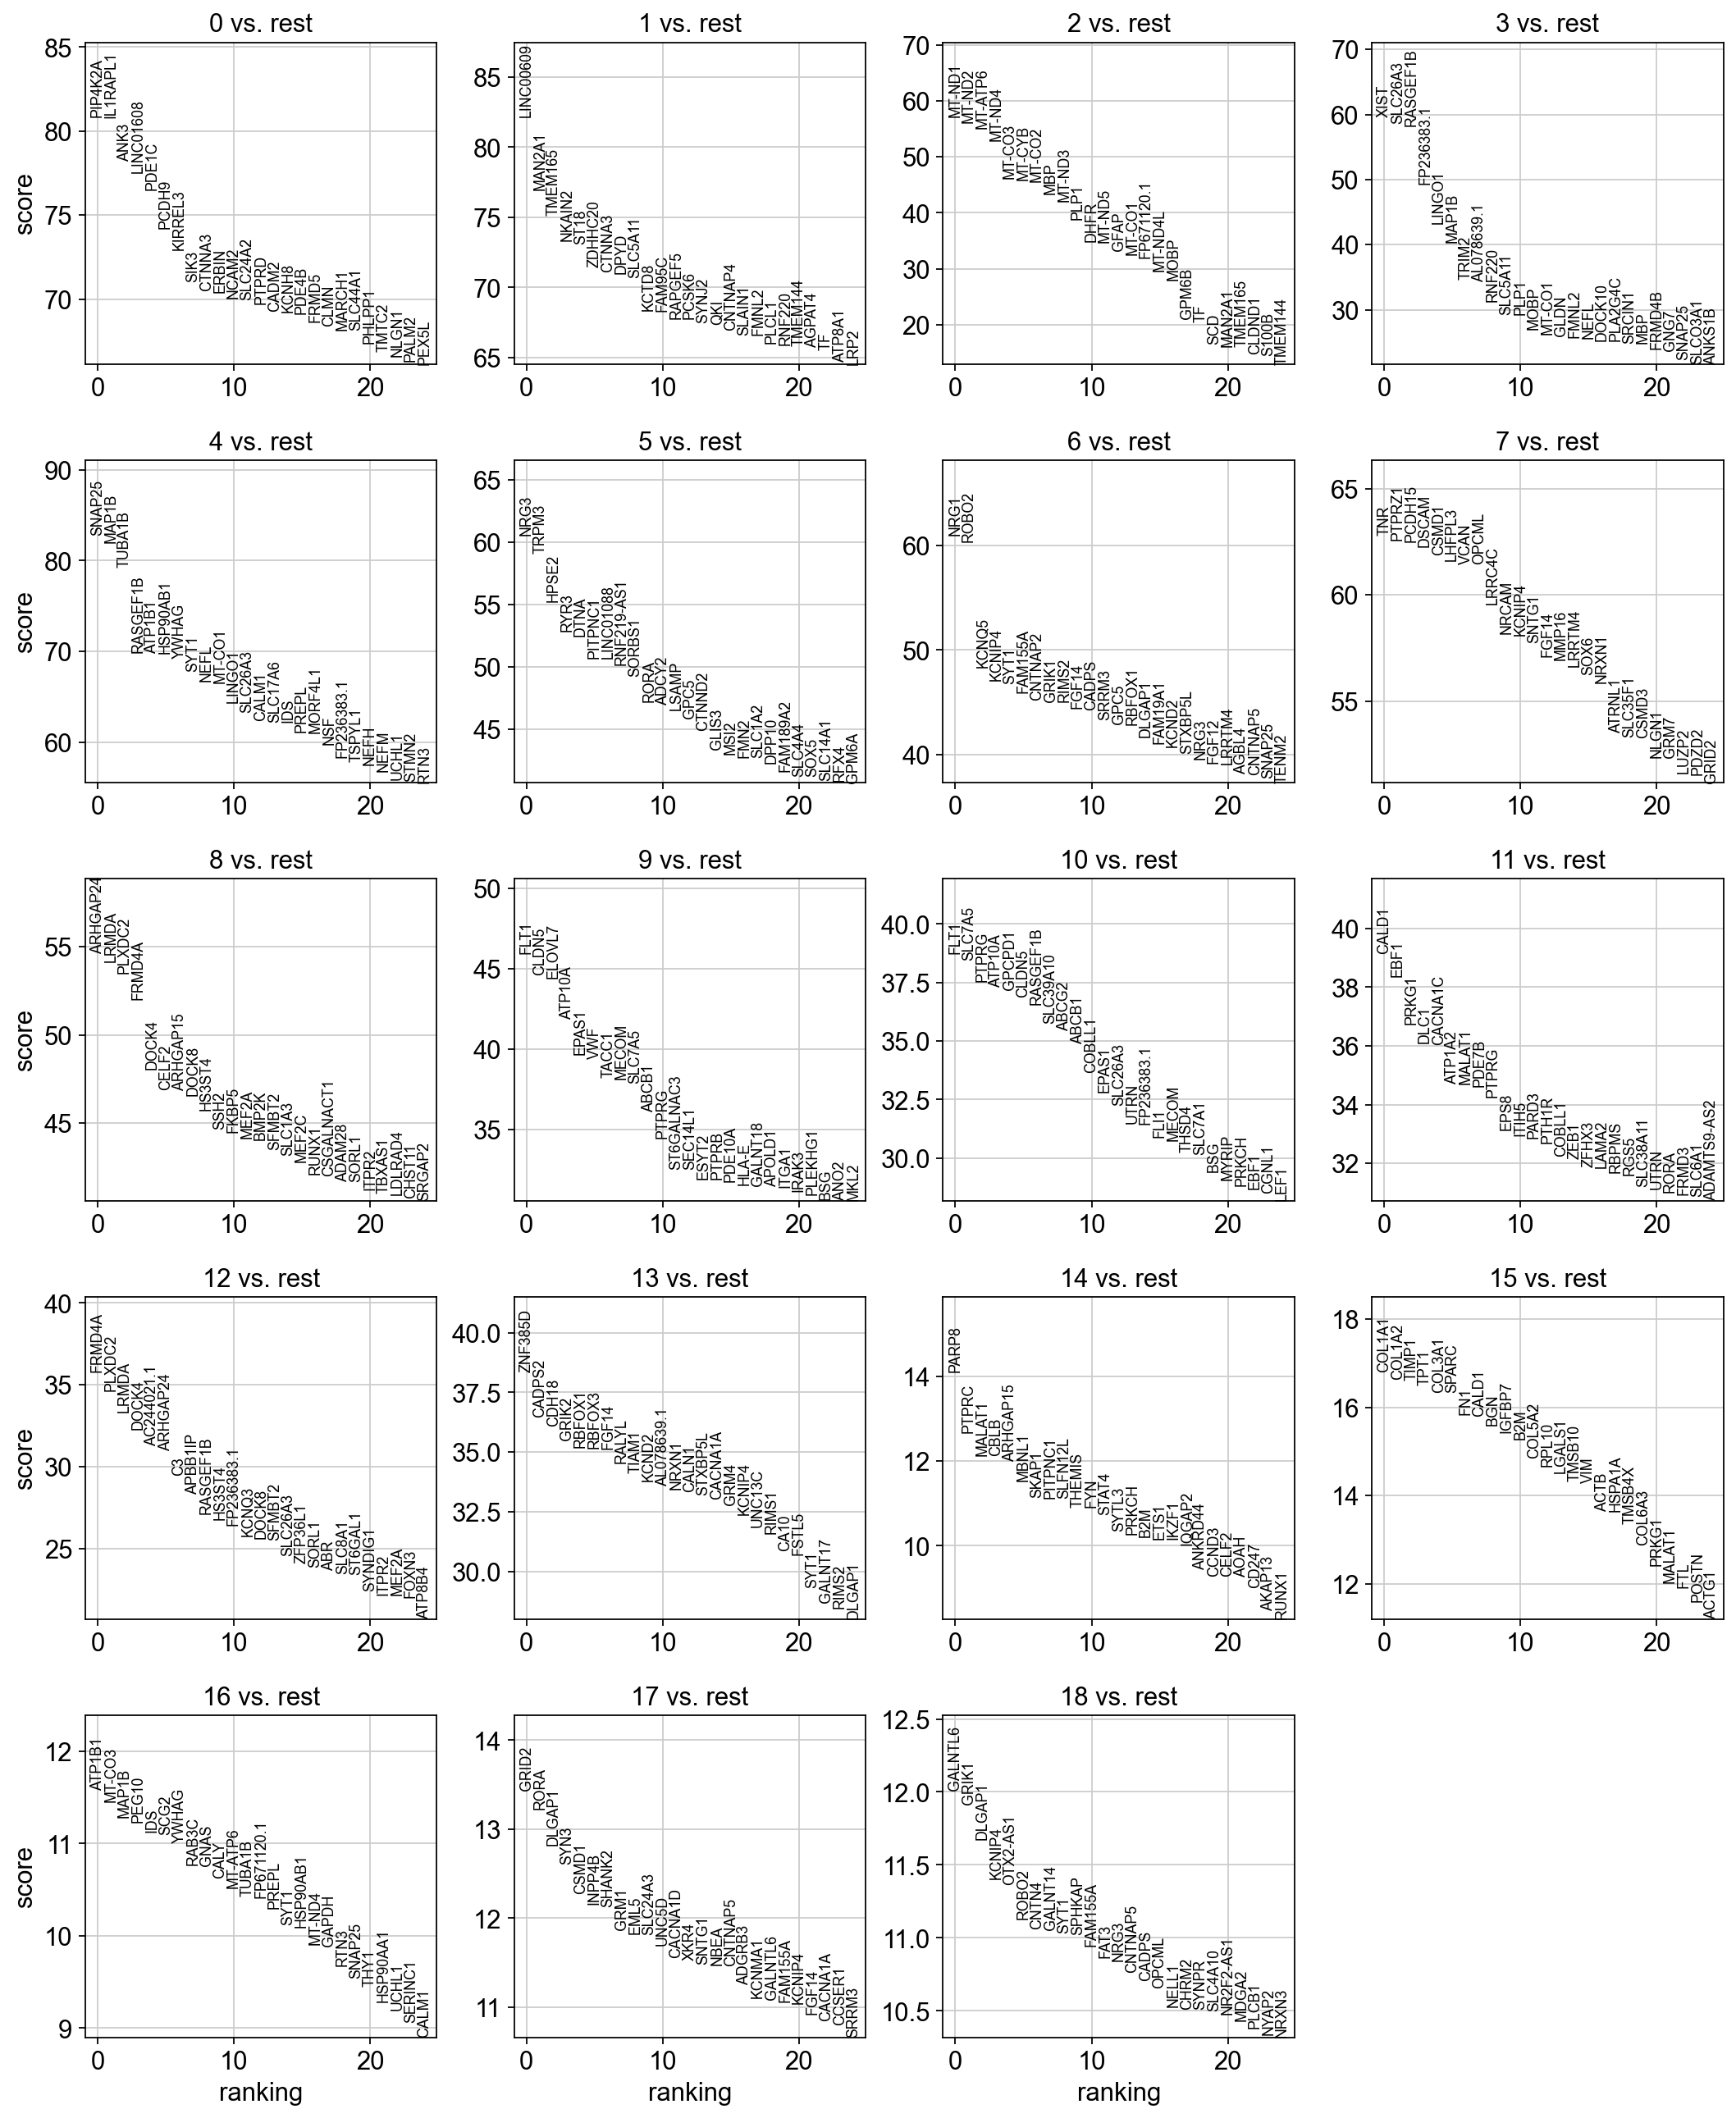

In [38]:
sc.tl.rank_genes_groups(merged_adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [39]:
merged_adata.write(results_file)

ranking genes
    finished (0:02:09)


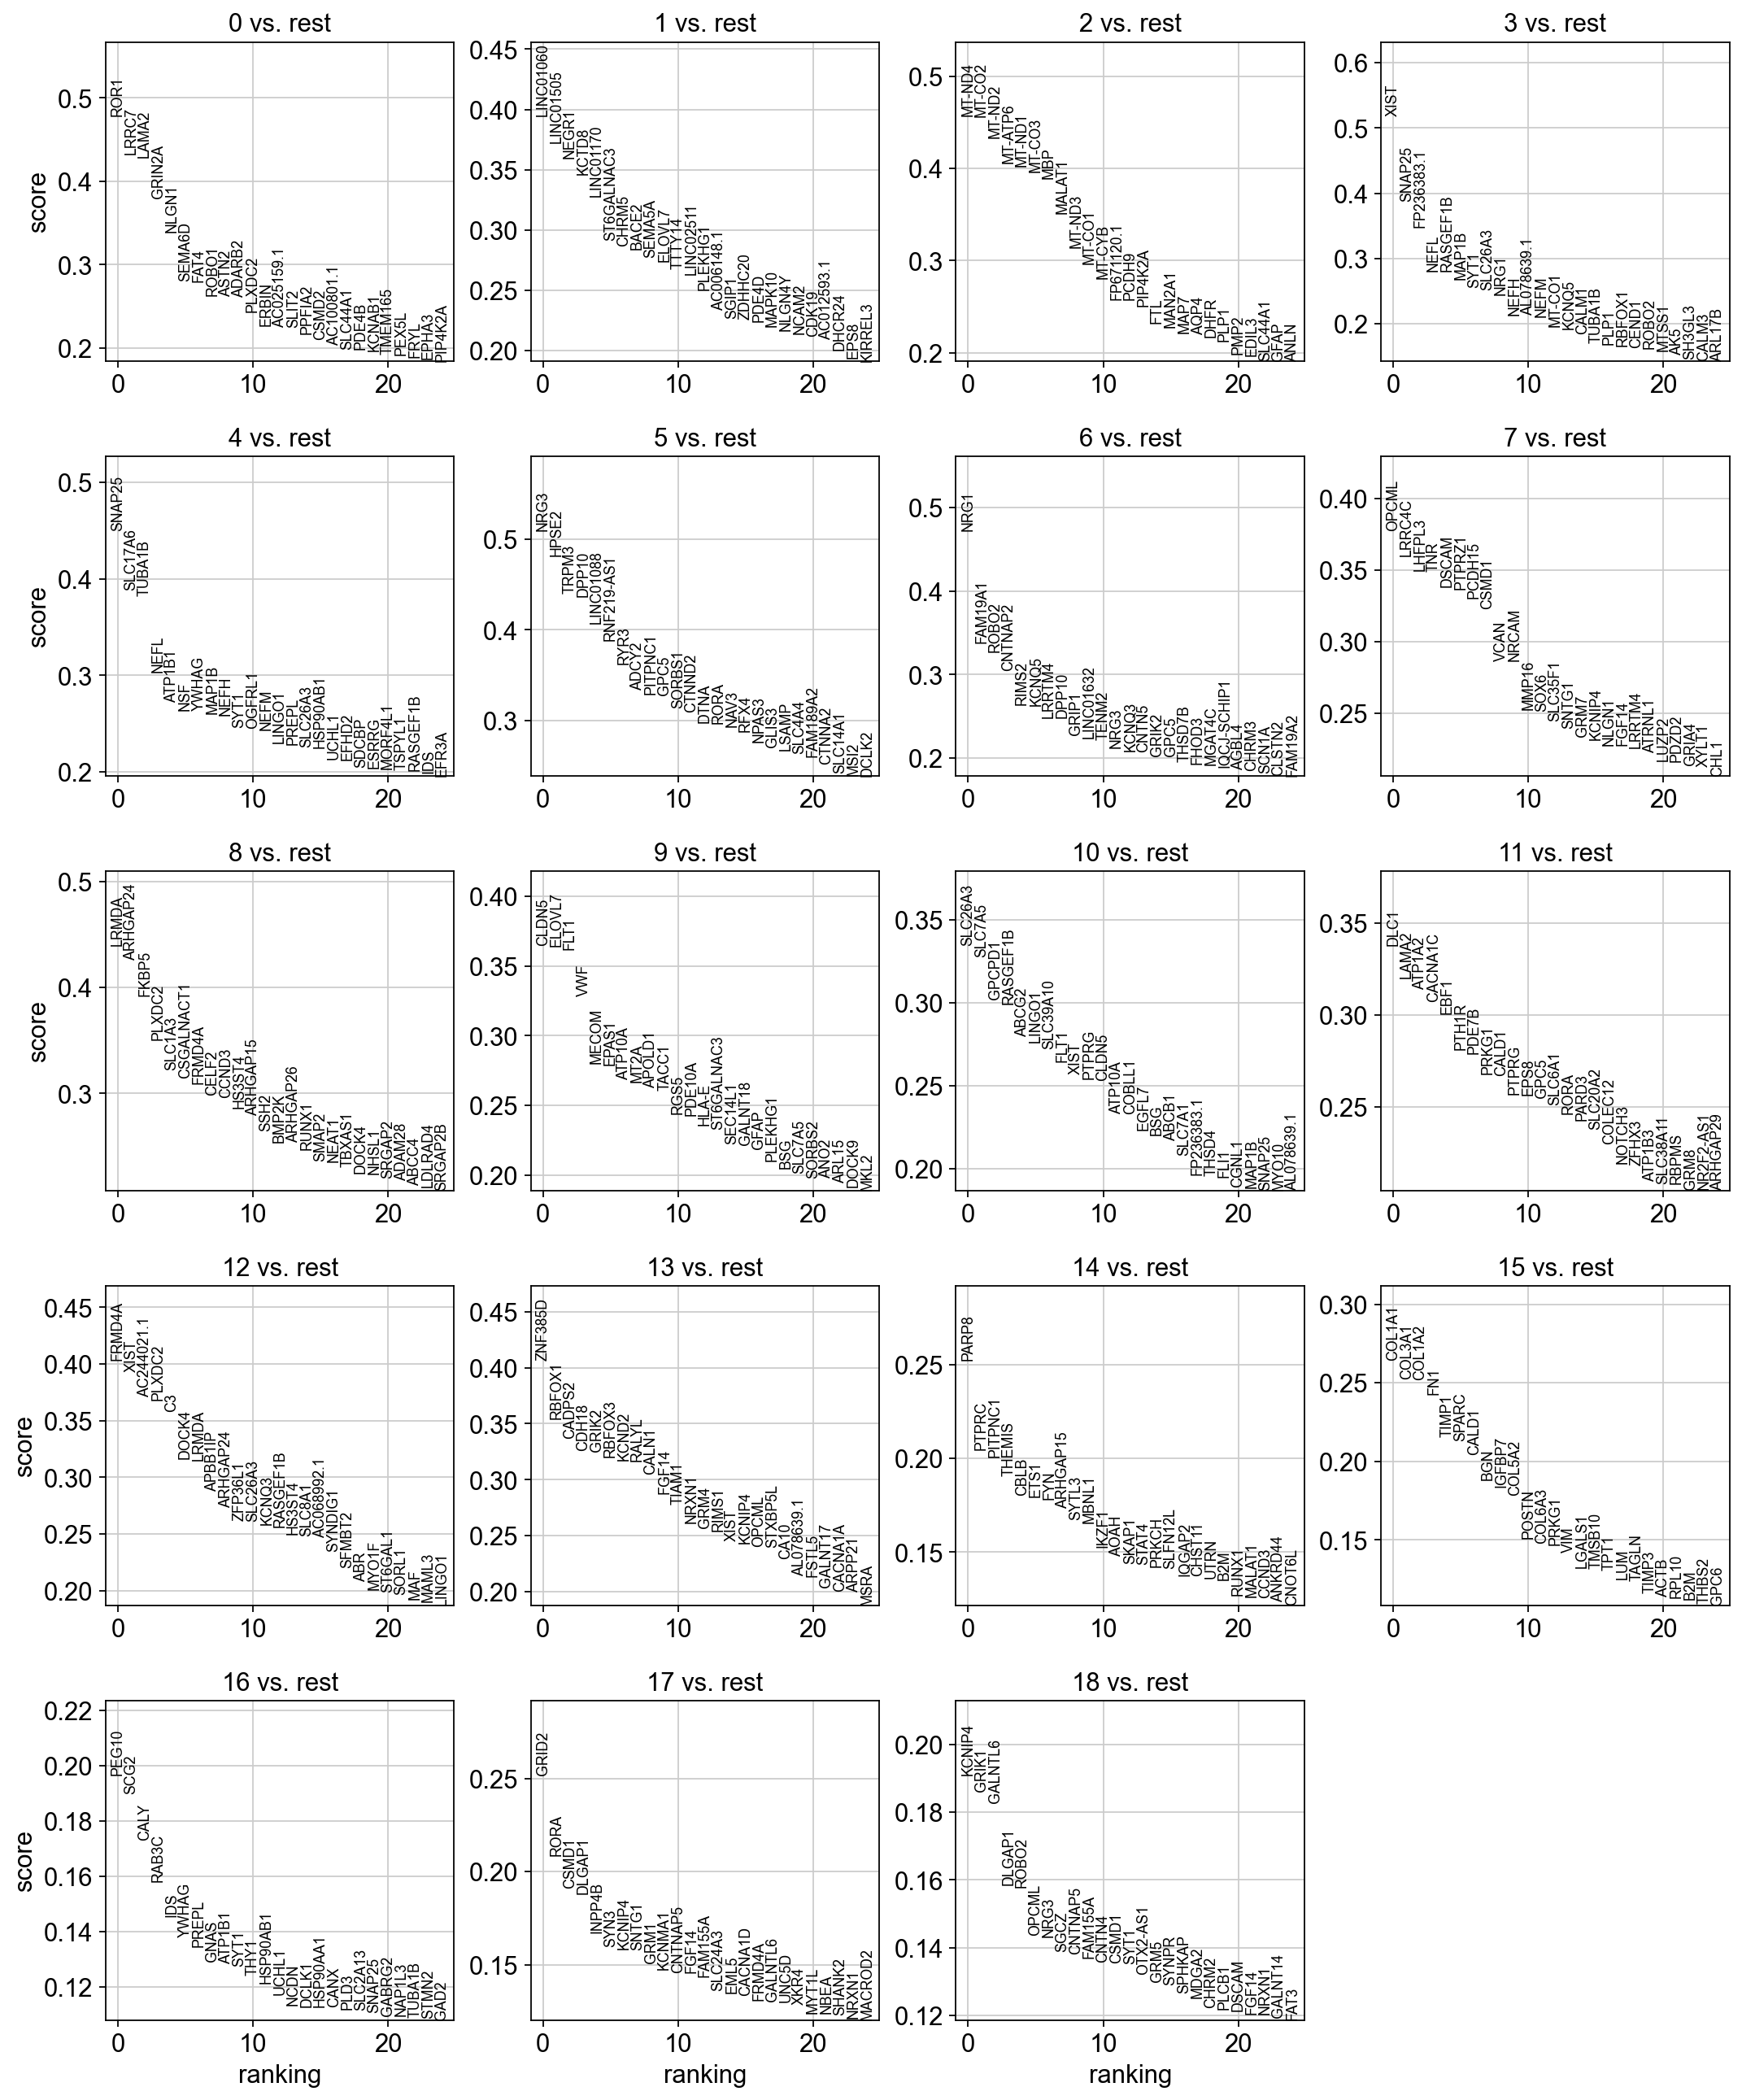

In [40]:
sc.tl.rank_genes_groups(merged_adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [41]:
merged_adata = sc.read(results_file)

c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [42]:
pd.DataFrame(merged_adata.uns["rank_genes_groups"]["names"]).head(10)

0          1        2           3         4           5        6  \
0    PIP4K2A  LINC00609   MT-ND1        XIST    SNAP25        NRG3     NRG1   
1   IL1RAPL1     MAN2A1   MT-ND2     SLC26A3     MAP1B       TRPM3    ROBO2   
2       ANK3    TMEM165  MT-ATP6    RASGEF1B    TUBA1B       HPSE2    KCNQ5   
3  LINC01608     NKAIN2   MT-ND4  FP236383.1  RASGEF1B        RYR3   KCNIP4   
4      PDE1C       ST18   MT-CO3      LINGO1    ATP1B1        DTNA     SYT1   
5      PCDH9    ZDHHC20   MT-CYB       MAP1B  HSP90AB1     PITPNC1  FAM155A   
6    KIRREL3     CTNNA3   MT-CO2       TRIM2     YWHAG   LINC01088  CNTNAP2   
7       SIK3       DPYD      MBP  AL078639.1      SYT1  RNF219-AS1    GRIK1   
8     CTNNA3    SLC5A11   MT-ND3      RNF220      NEFL      SORBS1    RIMS2   
9      ERBIN      KCTD8     PLP1     SLC5A11    MT-CO1        RORA    FGF14   

        7         8       9        10       11          12       13        14  \
0     TNR  ARHGAP24    FLT1      FLT1    CALD1      FRMD4A  ZNF385D     PARP8   
1  PTPRZ1     LRMDA   CLDN5    SLC7A5     EBF1      PLXDC2   CADPS2     PTPRC   
2  PCDH15    PLXDC2  ELOVL7     PTPRG    PRKG1       LRMDA    CDH18    MALAT1   
3   DSCAM    FRMD4A  ATP10A    ATP10A     DLC1       DOCK4    GRIK2      CBLB   
4   CSMD1     DOCK4   EPAS1    GPCPD1  CACNA1C  AC244021.1   RBFOX1  ARHGAP15   
5  LHFPL3     CELF2     VWF     CLDN5   ATP1A2    ARHGAP24   RBFOX3     MBNL1   
6    VCAN  ARHGAP15   TACC1  RASGEF1B   MALAT1          C3    FGF14     SKAP1   
7   OPCML     DOCK8   MECOM  SLC39A10    PDE7B     APBB1IP    RALYL   PITPNC1   
8  LRRC4C    HS3ST4  SLC7A5     ABCG2    PTPRG    RASGEF1B    TIAM1   SLFN12L   
9   NRCAM      SSH2   ABCB1     ABCB1     EPS8      HS3ST4    KCND2    THEMIS   

       15      16       17        18  
0  COL1A1  ATP1B1    GRID2   GALNTL6  
1  COL1A2  MT-CO3     RORA     GRIK1  
2   TIMP1   MAP1B   DLGAP1    DLGAP1  
3    TPT1   PEG10     SYN3    KCNIP4  
4  COL3A1     IDS    CSMD1  OTX2-AS1  
5   SPARC    SCG2   INPP4B     ROBO2  
6     FN1   YWHAG   SHANK2     CNTN4  
7   CALD1   RAB3C     GRM1   GALNT14  
8     BGN    GNAS     EML5      SYT1  
9  IGFBP7    CALY  SLC24A3    SPHKAP

In [43]:
result = merged_adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(10)

0_n  0_p        1_n  1_p      2_n  2_p         3_n            3_p  \
0    PIP4K2A  0.0  LINC00609  0.0   MT-ND1  0.0        XIST   0.000000e+00   
1   IL1RAPL1  0.0     MAN2A1  0.0   MT-ND2  0.0     SLC26A3   0.000000e+00   
2       ANK3  0.0    TMEM165  0.0  MT-ATP6  0.0    RASGEF1B   0.000000e+00   
3  LINC01608  0.0     NKAIN2  0.0   MT-ND4  0.0  FP236383.1   0.000000e+00   
4      PDE1C  0.0       ST18  0.0   MT-CO3  0.0      LINGO1   0.000000e+00   
5      PCDH9  0.0    ZDHHC20  0.0   MT-CYB  0.0       MAP1B   0.000000e+00   
6    KIRREL3  0.0     CTNNA3  0.0   MT-CO2  0.0       TRIM2  1.826394e-263   
7       SIK3  0.0       DPYD  0.0      MBP  0.0  AL078639.1  7.476636e-258   
8     CTNNA3  0.0    SLC5A11  0.0   MT-ND3  0.0      RNF220  7.622068e-216   
9      ERBIN  0.0      KCTD8  0.0     PLP1  0.0     SLC5A11  1.301781e-188   

        4_n  4_p  ...      14_n          14_p    15_n          15_p    16_n  \
0    SNAP25  0.0  ...     PARP8  3.194005e-45  COL1A1  1.924407e-63  ATP1B1   
1     MAP1B  0.0  ...     PTPRC  9.144750e-37  COL1A2  3.505756e-62  MT-CO3   
2    TUBA1B  0.0  ...    MALAT1  6.848184e-34   TIMP1  5.406673e-62   MAP1B   
3  RASGEF1B  0.0  ...      CBLB  8.030811e-34    TPT1  2.983133e-61   PEG10   
4    ATP1B1  0.0  ...  ARHGAP15  4.176443e-33  COL3A1  5.035457e-60     IDS   
5  HSP90AB1  0.0  ...     MBNL1  8.420563e-31   SPARC  5.072260e-60    SCG2   
6     YWHAG  0.0  ...     SKAP1  7.092668e-29     FN1  1.772126e-56   YWHAG   
7      SYT1  0.0  ...   PITPNC1  8.910903e-29   CALD1  2.840852e-56   RAB3C   
8      NEFL  0.0  ...   SLFN12L  9.779817e-29     BGN  6.608607e-55    GNAS   
9    MT-CO1  0.0  ...    THEMIS  1.028828e-27  IGFBP7  1.134709e-53    CALY   

           16_p     17_n          17_p      18_n          18_p  
0  5.060083e-31    GRID2  3.440486e-41   GALNTL6  2.965606e-33  
1  2.268732e-30     RORA  6.443163e-40     GRIK1  9.813452e-33  
2  1.581610e-29   DLGAP1  1.329344e-37    DLGAP1  1.707681e-31  
3  2.959351e-29     SYN3  1.864786e-36    KCNIP4  3.842806e-30  
4  9.618888e-29    CSMD1  1.164280e-34  OTX2-AS1  6.219085e-30  
5  1.236486e-28   INPP4B  5.038310e-34     ROBO2  9.194013e-29  
6  3.376445e-28   SHANK2  7.168493e-34     CNTN4  1.872860e-28  
7  5.003830e-27     GRM1  1.725895e-32   GALNT14  2.000606e-28  
8  5.215287e-27     EML5  2.994834e-32      SYT1  2.687764e-28  
9  2.151460e-26  SLC24A3  3.180559e-32    SPHKAP  3.048192e-28  

[10 rows x 38 columns]

ranking genes


c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:06)


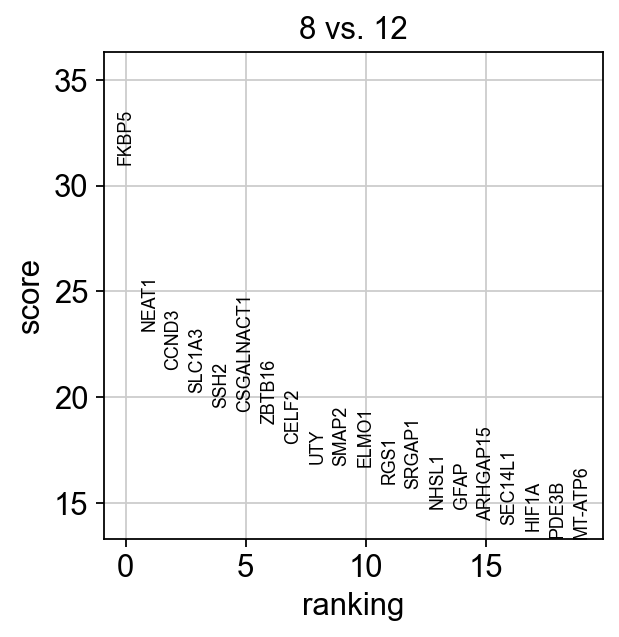

In [47]:
sc.tl.rank_genes_groups(merged_adata, "leiden", groups=["8"], reference="12", method="wilcoxon")
sc.pl.rank_genes_groups(merged_adata, groups=["8"], n_genes=20)

In [48]:
merged_adata = sc.read(results_file)

c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


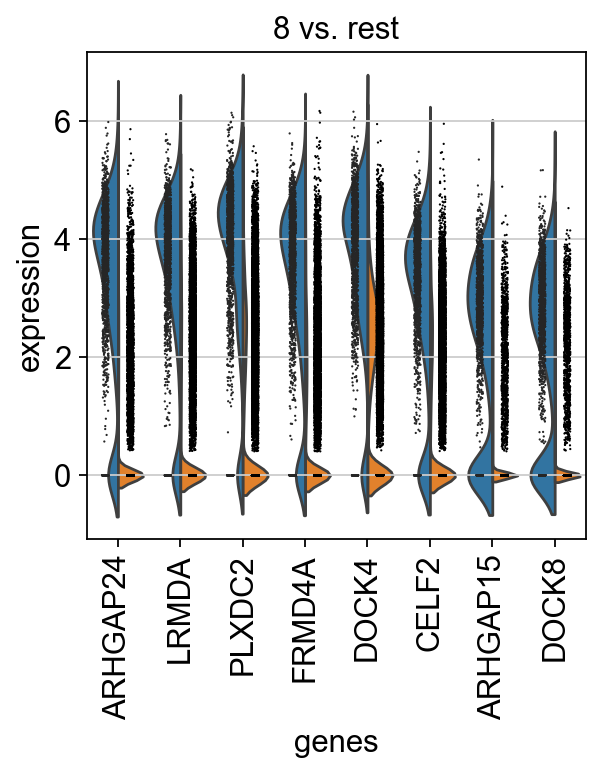

In [49]:
sc.pl.rank_genes_groups_violin(merged_adata, groups="8", n_genes=8)

c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed 

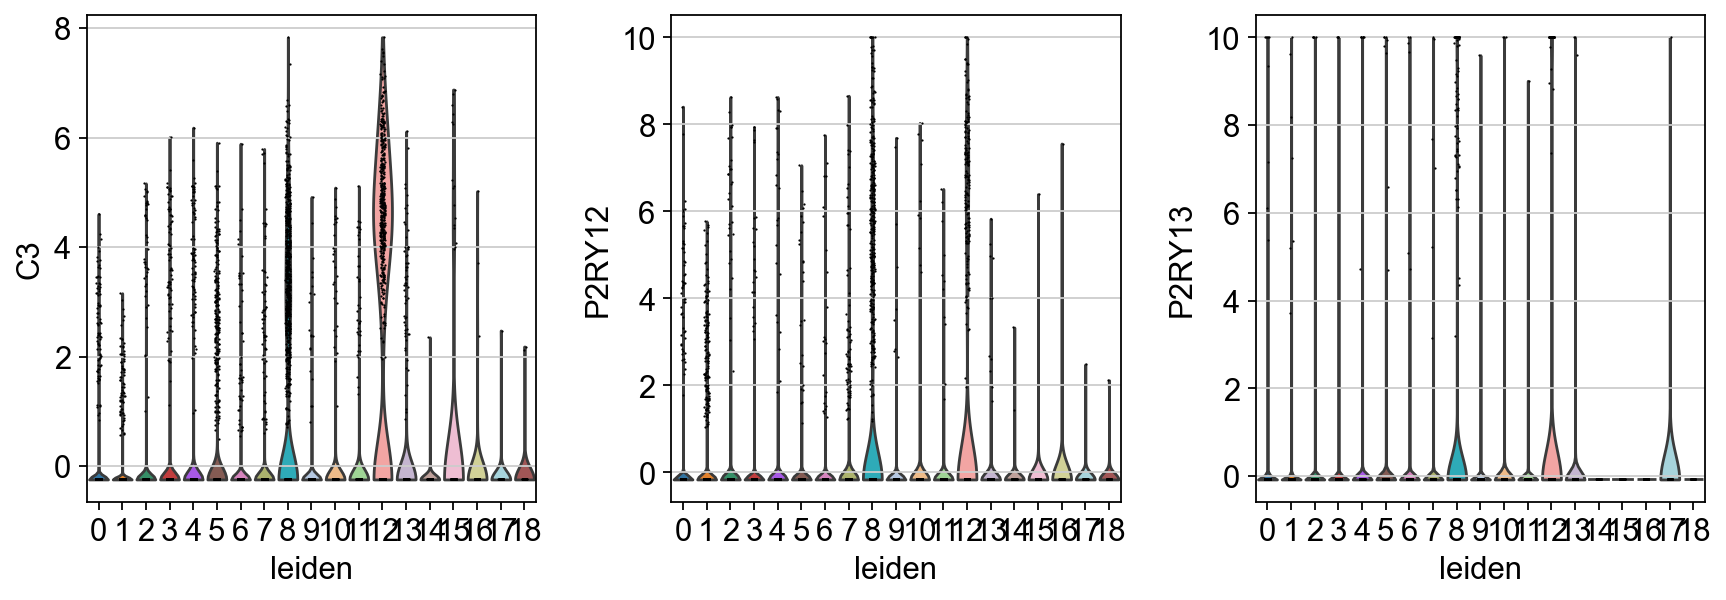

In [52]:
sc.pl.violin(merged_adata, ["C3", "P2RY12", "P2RY13"], groupby="leiden", use_raw=False)